In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

In [3]:
combine_data = [app_train, app_test]

In [4]:
print('Training data shape:', app_train.shape)
print('Test data shape:', app_test.shape)

Training data shape: (307511, 122)
Test data shape: (48744, 121)


### Exploratory Data Analysis

In [5]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

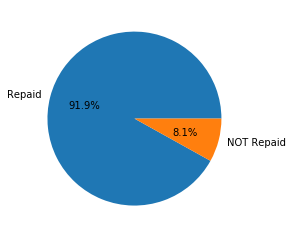

In [15]:
# Pie chart for data distribution
labels = ['Repaid', 'NOT Repaid']
size = [app_train['TARGET'].value_counts()[0], app_train['TARGET'].value_counts()[1]]
plt.pie(size, labels = labels, autopct = '%1.1f%%')
plt.show()

In [16]:
def missing_values_table(df):
    
    #Create a table containing missing value information
    mis_val = df.isnull().sum()
    mis_val_percent = mis_val * 100 / len(df)
    mis_val_table = pd.concat((mis_val, mis_val_percent), axis = 1)
    #print(mis_val_table)
    
    mis_val_table = mis_val_table[mis_val_table.iloc[:,1] != 0]
    mis_val_table = mis_val_table.rename(columns = {0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table = mis_val_table.sort_values('% of Total Values', ascending = False).round(1)
    
    print('There are total', app_train.shape[1], 'columns.')
    print(mis_val_table.shape[0], 'of them have missing values.')
    return mis_val_table

In [17]:
missing_values = missing_values_table(app_train)

There are total 122 columns.
67 of them have missing values.


In [18]:
missing_values.head()

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4


### Column types

In [19]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [20]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Using One-Hot Encoding to convert object type features into trainable values.

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        #print(app_train[col].nunique())
        if app_train[col].nunique() <= 2:
            le.fit(app_train[col].astype(str))
            app_train[col] = le.transform(app_train[col].astype(str))
            app_test[col] = le.transform(app_test[col].astype(str))  
            le_count += 1
print(f'{le_count} columns were label encoded.')        

4 columns were label encoded.


### Aligning Training and Testing data

In [22]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape:', app_train.shape)
print('Test Features shape:', app_test.shape)

Training Features shape: (307511, 242)
Test Features shape: (48744, 238)


In [23]:
train_label = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = train_label

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 238)


### Exploring Anomalies

In [24]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [25]:
(app_train['DAYS_EMPLOYED'] / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

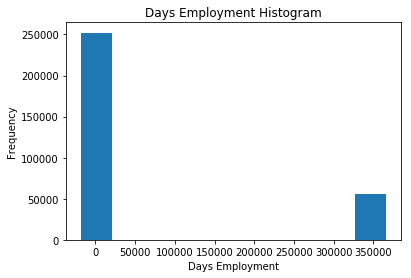

In [27]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')
plt.show()

In [28]:
len(app_train[app_train['DAYS_EMPLOYED'] > 300000])

55374

### Filling anomalies with np.nan and adding a new column indicating whether the record is anomalous or not.

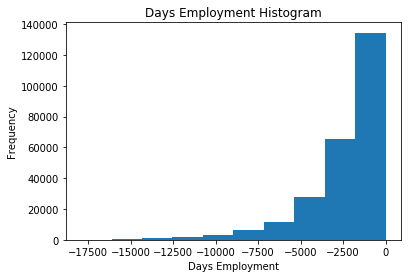

In [30]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] > 300000
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')
plt.show()

### Operations on test set.

In [50]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED'] > 300000
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [51]:
print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Other day-related data

In [48]:
Days_col = [col for col in app_train.columns if 'DAYS' in col]
Days_col.remove('DAYS_EMPLOYED_ANOM')

In [49]:
for col in Days_col:
    print((app_train[col] / -365).describe())
    print('\n')

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64


count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64


count    307511.000000
mean         13.660604
std           9.651743
min          -0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64


count    307511.000000
mean          8.203294
std           4.135481
min          -0.000000
25%           4.712329
50%           8.915068
75%          11.778082
max          19.717808
Name: DAYS_ID_PUBLISH, dtype: float64


count    307510.000000
mean          2.637969
std           2.265229
min          -0.000000
25%           0.7

### Now, all days-related data are in a reasonable range.

In [52]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))

print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
DAYS_EMPLOYED_ANOM                                        NaN
Name: TARGET, dtype: float64

Most Negati